# Convolutional Neural Network

This notebook will demonstrate a step-by-step understanding of a Convolutional Neural Network (CNN). In particular, we will be focussing on the implementation of a CNN in **PyTorch** for classification and regression tasks.

## Intuition (Visual)

<div>
<img src="https://www.deeplearningwizard.com/deep_learning/practical_pytorch/images/cnn1.png" width="1000"/>
</div>

## Intuition (Theoretical)

### Summary

- A convolutional neural network (CNN) is an artificial neural network (ANN), wherein connections between the nodes do not form a cycle (but instead move *forward* through the network).
- A CNN is comprised of:
1. Input Layer
2. Convolutional Layer
3. Hidden Layers
4. Output Layer
- A CNN can be shallow/deep, as well as narrow/wide. These properties depend on: 
1. Number of hidden layers
2. Number of hidden units in the layers.

### Convolutional Layer

- Unlike traditional neural networks, CNNs use convolutions, an element-wise multiplication operation, instead of general matrix multiplication, in at least one of their layers. The convolution occurs between the kernel/filter and the input data. 
- The kernel/filter is an $m \times n$ matrix which slides across the input data (performing convolution), in order to extract features from the input. A stride may be applied to the kernel i.e. the number of columns/rows to skip during each kernel slide.
- Once this is complete, we apply a pooling method to downsample the data - this reduces the size of feature maps, which in turn makes computation faster because the number of training parameters is reduced. Two popular pooling strategies are maximum and average pooling.
- Sometimes we apply a padding before the convolution happens - it is useful when we want to retain spatial information and ensure that the output feature maps have the same spatial dimensions as the input. It can also help in capturing features near the borders of the input image.

<div>
<img src="https://media.geeksforgeeks.org/wp-content/uploads/20220302180104/Group16.jpg" width="500"/>
<br>
<img src="https://miro.medium.com/max/700/1*5BwZUqAqFFP5f3wKYQ6wJg.gif" width="500"/>
<br>
<img src="https://cdn-images-1.medium.com/max/726/1*fXxDBsJ96FKEtMOa9vNgjA.gif" width="500"/>
<br>
<img src="https://www.deeplearningwizard.com/deep_learning/practical_pytorch/images/cnn10-2n.png" width="1000"/>
</div>

### Extra

- A CNN is commonly used for analyzing visual imagery. 
- CNNs are also known as Shift Invariant or Space Invariant Artificial Neural Networks (SIANN) due to their shared-weight architecture. The convolution kernels or filters in CNNs slide across input features, generating translation-equivariant responses known as feature maps. However, despite their name, most CNNs are not fully invariant to translation due to downsampling operations applied to the input.
- CNNs are a regularization technique for multilayer perceptrons (MLP)/FFNN, which are fully connected networks. MLPs have a higher risk of overfitting data due to their full connectivity. CNNs, on the other hand, exploit the hierarchical patterns in data. Instead of processing the entire input at once, CNNs break it down into smaller features using filters. These filters extract relevant information from different regions of the input. As the network progresses through layers, these features are combined and assembled into more complex patterns, enabling the network to learn abstract representations of the input. This hierarchical approach allows CNNs to learn complex patterns efficiently while reducing the risk of overfitting. Compared to other networks, CNNs have lower connectivity and complexity.

## Code

In [5]:
# Imports
from typing import Callable
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

Since we are using ```torch```, try not to mix ```numpy``` into any calculation or dataset conversions. Additionally, check if you have access to ```GPU``` via ```torch.cuda.is_available()```. To use GPU, apply ```torch.device("cuda" if torch.cuda.is_available() else "cpu")```.

### 1. Load Dataset

- For this example we will be looking at famous MNIST dataset (for multiclass classification).
- This dataset is readily available via the *torch* library - in some cases, you may need to load/create the data yourselves.
- If so, it can be useful to store the data similarly to the way that *torch* does it.

In [6]:
# Training set
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
# Test set
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

### 2. Process Data

- Depending on if you are loading the data or creating the data yourself, you may need to clean the data so that the model can use it. This is perhaps the most trickiest part throughout a Data Science/Machine Learning pipeline.
- In this case, it is good to make *batches* of the dataset so that we can manipulate the way the data is being trained e.g. allow shuffling when training per epoch etc...

In [7]:
# Decide batch size in each portion of the data loader object
batch_size = 128
# Decide the sizes of the datasets
train_size = int(0.8 * len(train_dataset)) 
val_size = len(train_dataset) - train_size 
# Split the dataset
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
# Create DataLoaders for each dataset
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size, 
                                         shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

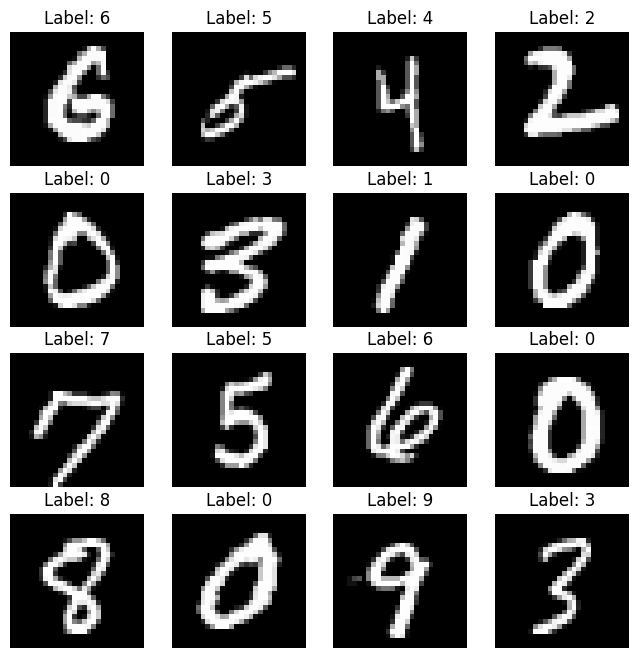

In [8]:
# Visualise data
dataiter = iter(train_loader)
images, labels = next(dataiter)
num_images = 16
# Create plots
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(num_images):
    # Convert to 1-D tensor
    img = images[i].squeeze()
    # Images have 1 channel i.e. greyscale so need to use "gray" mapping
    axs[i].imshow(img, cmap='gray')
    axs[i].title.set_text('Label: ' + str(labels[i].item()))
    axs[i].axis('off')  # Hide axis
plt.show()

Using ```squeeze```, we convert each image in a batch to a 1D tensor of i.e. originally we would have ```[128, 1, 28, 28]```, but after squeeze we have ```[128, 28, 28]```. Note that the $128$ refers to the *batch size*, the $\left[28, 28\right]$ refers to the *image dimension* and the $1$ refers to the tensor structure. Also, if we look at ```len(dataiter)```, we obtain $468$ - this number refers to the number image collections present (where in each collectin, we select a batch of $128$ images from the entire dataset). Hence, the number of total images in the entire MNIST dataset can be calculated as ```(len(iter(train_loader)) + len(iter(test_loader))) x 128```, which gives us $70016$.

### 3. Create Model

- Once the data is ready, we can now look to choose what kind of model we want to create.
- For this notebook, we will implement a CNN. Other models exist e.g. Recurrent Neural Network (RNN) etc...

In [27]:
# Create CNN
class CNN_Long(nn.Module):
    def __init__(self):
        super(CNN_Long, self).__init__()
        # Convolution Layer 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        # Convolution Layer 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        # Linear Function (applied to convolution layer output) i.e. pre-activation first hidden layer.
        self.fc1 = nn.Linear(32 * 7 * 7, 10) 

    def forward(self, x):
        # Convolution Layer 1
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        # Convolution Layer 1
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        # Original size: (128, 32, 7, 7) --> New out size: (128, 32*7*7)
        out = out.view(out.size(0), -1)
        # Linear Function (applied to convolution layer output) i.e. pre-activation first hidden layer.
        out = self.fc1(out)
        return out

Using ```nn.LogSoftmax``` than ```nn.Softmax``` helps improve numerical stability.
We can condense the architecture above by using ```nn.Sequential``` in the ```__init__``` step:

In [28]:
# Create CNN
class CNN_Short(nn.Module):
    def __init__(self):
        # Allows for multiple inheritance
        super(CNN_Short, self).__init__()
        # Create network
        self.net1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
                                 nn.ReLU(),
                                 nn.MaxPool2d(kernel_size=2),
                                 nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
                                 nn.ReLU(),
                                 nn.MaxPool2d(kernel_size=2))
        self.net2 = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x: torch.Tensor):
        # Create network
        out = self.net1(x)
        # Original size: (128, 32, 7, 7) --> New out size: (128, 32*7*7)
        out = out.view(out.size(0), -1)
        # Linear Function (applied to convolution layer output) i.e. pre-activation first hidden layer.
        out = self.net2(out)
        return out

The reason that ```nn.LogSoftmax``` has been removed is because later on, we will be defining our loss as ```nn.CrossEntropyLoss```, which takes into account the ```nn.LogSoftmax``` calculation.

### 4. Instantiate Model Class

- Now the architecture and data are in the correct form, we can being initialise our class.
- Once this is complete, we can begin training.
- We may run into some errors from time to time - this usually occurs because of incompatible dimensions or incorrect data types so be sure to fix these.

In [29]:
# Create model
model = CNN_Short()

### 5. Instantiate Optimiser and Loss Function

- In order to update our weights (to find the optimal ones) and track the model performance, we need to choose an optimiser and loss function.
- The loss function is typically straightforward (as it depends on the machine learning task) however there are a plethora of optimisers you could use e.g. SGD, Adam etc... Usually this is a trial and error choice to find the *best* one.

In [30]:
# Instantiate loss function
loss_fn = nn.CrossEntropyLoss()
# Instantiate optimiser
opt = torch.optim.Adam(params=model.parameters())

It is important to recognise that ```model.parameters()``` are the parameters that we wish to update/optimise. If these are not correctly defined in the ```__init__```, then the network may not be fully functional.

### 6. Model Training

- We are now ready to train the model.
- Through training, it is also useful to record some metrics to see how the model is performing.
- We use the loss of model to dictate potential *early stopping* of the model (although we could use other measures as well) i.e. if the model loss starts increasing after it has decreased, we are potentially overfitting and so should stop training and keep the model at that instance. This can be applied per ```epoch``` or at some multiple of ```n_iters```.
- When evaluating the model, it is necessary to apply ```model.eval()``` along with ```torch.no_grad()``` and once this is complete, to apply ```model.train()``` after if the model architecture includes layers of ```dropout```, ```batch_normalisation``` etc...
- The training and evaluation phase below is a generalised architecture; there are other variations of this which you may want to experiment with!

In [31]:
# Calculate number of epochs
n_iters = 15000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

In [32]:
# Initialize the early stopping parameters
best_val_loss = float('inf') 
patience = 3
epochs_no_improve = 0
early_stop = False

In [33]:
# Train model
for epoch in range(num_epochs):
    # Iterate through entire collection (per batch)
    for images, labels in train_loader:
        # Clear gradients with respect to parameters
        opt.zero_grad()
        # Forward pass
        outputs = model(images)
        # Calculate loss
        loss = loss_fn(outputs, labels)
        # Backward pass
        loss.backward()
        # Parameter update
        opt.step()
    # Evaluate model (NOTE: In the evaluation phase, the model parameters do not need updating!)
    with torch.no_grad():
        # Initialise validation loss 
        val_loss = 0
        # Initialise secondary metric
        correct = 0
        # Iterate through entire collection (per batch)
        for images, labels in val_loader: 
            # Forward pass
            outputs = model(images)
            # Obtain predictons
            _, preds = torch.max(outputs.data, dim=1)
            # Total correct predictions
            correct += (preds == labels).sum()
            # Calculate loss
            loss = loss_fn(outputs, labels)
            # Accumulate loss
            val_loss += loss.item()
        # Record secondary metric
        val_acc_score = 100 * correct / len(val_loader.dataset)
        # Print loss and accuracy
        print(f"Epoch: {epoch} | Validation loss: {val_loss} | Validation accuracy: {val_acc_score}")
        # If the validation loss is at a new minimum, save the model
        if val_loss < best_val_loss:
            torch.save(model.state_dict(), 'best_model.pth')
            best_val_loss = val_loss
            epochs_no_improve = 0
        # If the validation loss is not improving for certain patience, stop training!
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                early_stop = True
                break

Epoch: 0 | Validation loss: 10.514980375766754 | Validation accuracy: 96.73332977294922
Epoch: 1 | Validation loss: 6.157938990741968 | Validation accuracy: 98.13333129882812
Epoch: 2 | Validation loss: 5.270256502553821 | Validation accuracy: 98.44166564941406
Epoch: 3 | Validation loss: 4.486941103124991 | Validation accuracy: 98.64167022705078
Epoch: 4 | Validation loss: 4.166121706366539 | Validation accuracy: 98.71666717529297
Epoch: 5 | Validation loss: 4.167645071167499 | Validation accuracy: 98.80000305175781
Epoch: 6 | Validation loss: 3.710825164569542 | Validation accuracy: 98.85832977294922
Epoch: 7 | Validation loss: 4.055937550263479 | Validation accuracy: 98.67500305175781
Epoch: 8 | Validation loss: 3.534041949780658 | Validation accuracy: 98.88333129882812
Epoch: 9 | Validation loss: 4.233171322615817 | Validation accuracy: 98.7249984741211
Epoch: 10 | Validation loss: 4.043998267385177 | Validation accuracy: 98.82499694824219
Epoch: 11 | Validation loss: 4.42812903039

If the validation loss is displaying ```inf```, then something has gone wrong with the data or the model - debug the code to check which! 

In [34]:
# Load saved model
model.load_state_dict(torch.load('best_model.pth')) 

<All keys matched successfully>

### 7. Model Testing

- Now that the model has been trained and evaluated, we can test the optimal model on unseen data.
- This is a crucial part as it shows whether or not the model is generalisable i.e. has low variance.

In [36]:
# Test model
correct = 0
for images, labels in test_loader: 
    # Forward pass
    outputs = model(images)
    # Obtain predictons
    _, preds = torch.max(outputs.data, dim=1)
    # Total correct predictions
    correct += (preds == labels).sum()
# Record secondary metric
test_acc_score = 100 * correct / len(test_dataset)
print(f"Test accuracy: {test_acc_score}")

Test accuracy: 99.0999984741211


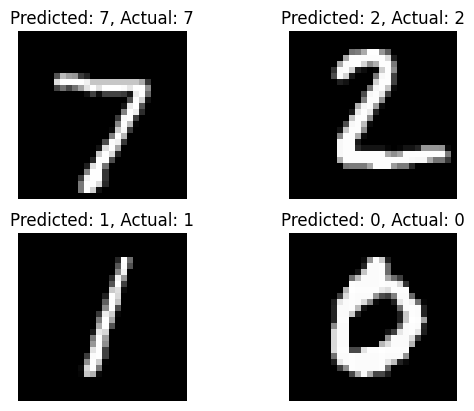

In [37]:
# Visualise predictions
images, labels = next(iter(test_loader))
# Predict labels for the test images
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)  
# Plot the images with their predicted labels
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i].view(28, 28), cmap='gray') 
    plt.title(f"Predicted: {predicted[i]}, Actual: {labels[i]}")
    plt.axis('off')
plt.show()

Note that using accuracy may not be the best metric to use to quantify the model performance - there are other metrics we can use e.g. F-1, Precision etc... Additionally, the shape of the images being passed into the model is the standard ```[128, 1, 28, 28]```, rather than ```[128, 28, 28]``` (which is the input to a FFNN that takes in a ```[28, 28]``` tensor, not ```[1, 28, 28]``` tensor).

## Final Remarks

Thank you for reading this notebook. Note that there are other implementations of feed-forward neural networks (which I would advise you to take a look at to see any differences of similarities with this version).
If there are any mistakes or things that need more clarity, feel free to respond and I will be happy to reply 😊.

© *PolyNath 2023*